In [ ]:
# Wikipedia App

## "Map" with One Mean

__Conclusion__: _It works with RidgeCV, alpha=0.1_

In [2]:
try:
    initialized
except NameError:
    ## Matplotlib configuration
    %matplotlib inline
    initialized = True

from math import ceil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.linear_model import RidgeCV, LinearRegression
from lib.wikipedia import DataFrameBuilder
from lib import Humanizer, Plotter, Model, OneManyModel, TwoMeanModel, Outlier, ExperimentInfo, TaskMeanModel
from mynotebook import *

df_builder = DataFrameBuilder()

## Wikipedia Application

### Target

,input size (GiB),workers,outliers,samples,available
0,45,4,3,30,27
1,45,8,1,30,29
2,45,16,1,30,29
3,45,32,2,30,28
4,45,64,3,30,27


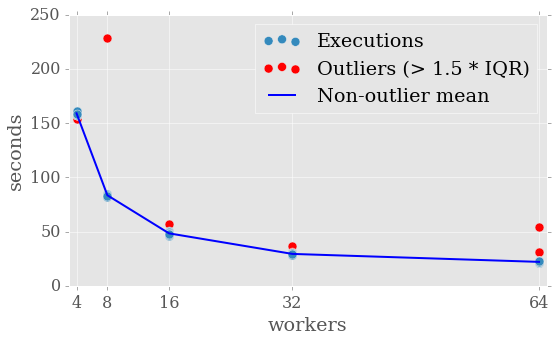

Total target application duration using the complete dataset (45 GB).


In [3]:
target_out = df_builder.get_target_df(stage=0)
humanizer = Humanizer(size=Humanizer.SIZE_GIB)
plotter = Plotter((3, 65), (0, 250))
caption = 'Total target application duration using the complete dataset (45 GB).'
target = process_outliers(target_out, humanizer, plotter, caption)

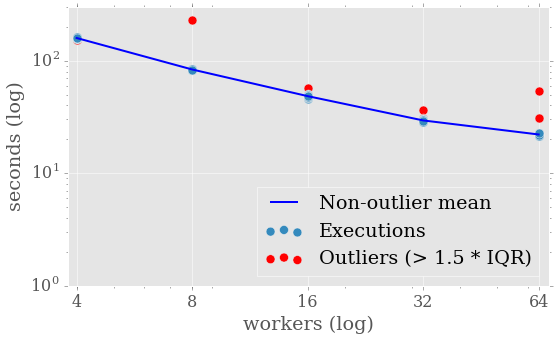

The same as above in log-log scale.


In [4]:
plotter = Plotter((3.8, 68), (1, 300), logx=True, logy=True, loc='lower right')
target_out['outlier'] = Outlier.is_outlier(target_out)
plotter.plot_outliers(target_out)
print('The same as above in log-log scale.')

### "Map" stage

In [5]:
exp_info = ExperimentInfo(ExperimentInfo.SS2, 2, 128 * 1024 ** 2)
caption = 'Durations of the first tasks using 1-GB input data.'
prof_many_first_out, prof_many_nonfirst_out = df_builder.get_strong_scaling_tasks_df(2, stage=0, threads=exp_info.threads)
prof_many_out = pd.concat([prof_many_first_out, prof_many_nonfirst_out])

,workers,input,ms,outlier
9,1,1073741798,3169,False
107,3,1073741798,8918,False
111,3,1073741798,9154,False


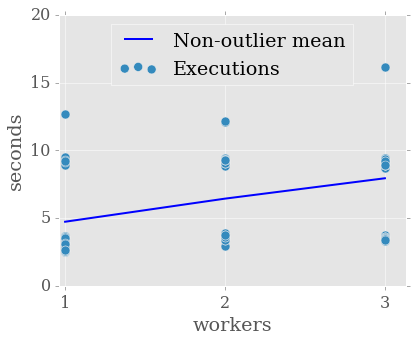

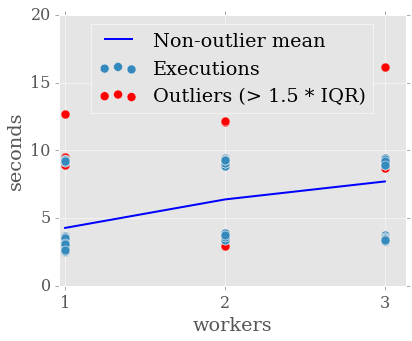

In [6]:
humanizer = Humanizer(size=Humanizer.SIZE_MIB)
plotter = Plotter((0.96, 3.13), (0, 20), logx=False, logy=False, loc='upper center', figsize=(6, 5))

prof_many_out['outlier'] = [False] * len(prof_many_out)
display(prof_many_out.sample(3))
plotter.plot_outliers(prof_many_out)

# Process outliers separately for first and nonfirst tasks
prof_many_first_out['outlier'] = Outlier.is_outlier(prof_many_first_out)
prof_many_nonfirst_out['outlier'] = Outlier.is_outlier(prof_many_nonfirst_out)
prof_many_out = pd.concat([prof_many_first_out, prof_many_nonfirst_out])
plotter.plot_outliers(prof_many_out)

prof_many = prof_many_out[~prof_many_out.outlier].drop('outlier', axis=1)

In [83]:
model_many = Model(LinearRegression(), features=['workers'], ycol='ms', use_log=False)
model_many_orig = Model(LinearRegression(), features=['workers'], ycol='ms', use_log=False)
model, prof = model_many, prof_many

_prof = prof.copy()
_prof.workers *= 48542876756 / 1073741798

_prof = _prof.groupby(['workers', 'input']).mean().reset_index()
display(_prof.sample(3))
display(model.fit_score(_prof))
linreg = model.get_linreg()
display(linreg.intercept_, linreg.coef_)

model_many_orig.fit(_prof)

,workers,input,ms
0,45.21,1073741798,4270.93
1,90.42,1073741798,6373.38
2,135.63,1073741798,7700.16


[0.02920897447219094,
 ((45.209078054349895, 1073741798.0), 0.030269456884683507),
 ((90.41815610869979, 1073741798.0), 0.04056835559570001),
 ((135.62723416304968, 1073741798.0), 0.016789110936189323)]

2685.598506401137

array([ 37.92629279])

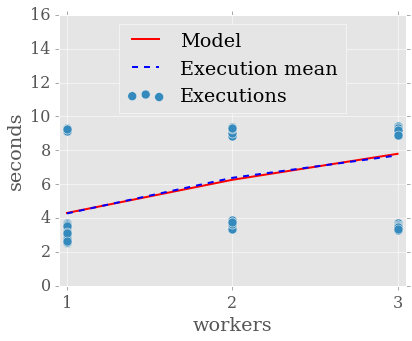

In [74]:
model = model_many
prof = prof_many

plotter = Plotter((0.95, 3.05), (0, 16), loc='upper center', figsize=(6, 5))
plotter.plot_model(model, prof)

In [75]:
# Ajustde do modelo

# Proporção entre primeiras e não primeiras tarefas
old, new = model_many_orig.get_linreg(), model_many.get_linreg()
new.coef_[0] = old.coef_[0] * (48542876756 / 1073741798)

old_workers = prof_many.workers.min()
new_workers = old_workers * (48542876756 / 1073741798)

display(old_workers, new_workers)
display(model_many_orig.predict(pd.DataFrame({'workers': [old_workers, new_workers]})))
display(model_many.predict(pd.DataFrame({'workers': [old_workers, new_workers]})))

#old_pred = model_many_orig.predict(pd.DataFrame({'workers': [old_workers]}))[0]
#new_pred = model_many.predict(pd.DataFrame({'workers': [new_workers]}))[0]
#display(old_pred, new_pred)

#new.intercept_ = old.intercept_ + new_pred - old_pred

display(old.intercept_, old.coef_)
display(new.intercept_, new.coef_)

1

45.209078054349895

array([  4300.23287873,  33793.56263076])

array([  4.30023288e+03,   1.29145269e+44])

12.070199075615303

array([ 0.5409184])

12.070199075615303

array([ 24.45442198])

In [50]:
exp_info = ExperimentInfo(ExperimentInfo.ONE, 2, 128 * 1024**2)
prof_one_first_out, prof_one_nonfirst_out = df_builder.get_1VM_tasks_df(stage=0, threads=exp_info.threads)
prof_one_first = remove_outliers(prof_one_first_out[prof_one_first_out.input > 200 * 1024**2])
prof_one_nonfirst = remove_outliers(prof_one_nonfirst_out[prof_one_nonfirst_out.input > 200 * 1024**2])
prof_one = pd.concat([prof_one_first, prof_one_nonfirst])

[0.010377529810177937,
 ((1, 268425644), 0.008666946639918387),
 ((1, 536816741), 0.01531942188693472),
 ((1, 1073741798), 0.0071462209036807015)]

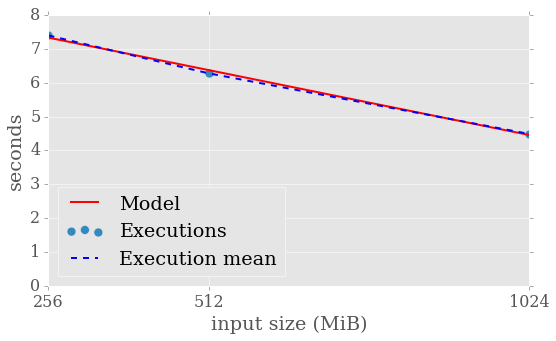

In [84]:
model_one = Model(LinearRegression(), features=['input'], ycol='ms', use_log=False)
model, prof = model_one, prof_one

prof = prof.groupby(['workers', 'input']).mean().reset_index()
model.fit(prof)
display(model.score(prof))
plotter = Plotter()
plotter.plot_model(model, prof)

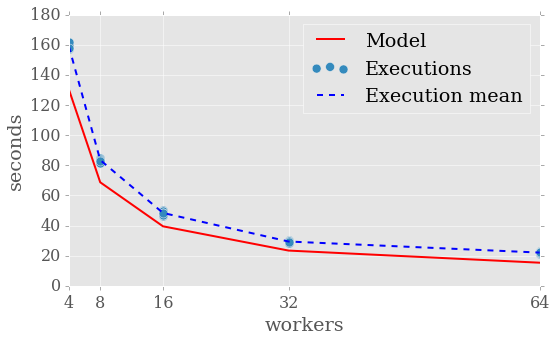

In [85]:
stage_model = TaskMeanModel(model_many, exp_info.threads, exp_info.block_size)
plotter = Plotter()
plotter.plot_model(stage_model, target)

In [86]:
# Ideia: pegar slope com first e nonfirst misturados (subtrai a média)